# Problem Set 2 - Text Mining: models and algorithms - DSMD 21-22

## Team mebers

- Alejandra Vicaria
- Andrés Felipe Virgüez
- Niamh Eleanor Sheehan
- Kalliope Stassinos

## Table of contents

- Libraries and previous setup
- Exercise 1
- Exercise 2
- Exercise 3
- Exercise 4
- Exercise 5
- Output format
- Extra exercises
    - Extra 1
    - Extra 2

### Libraries and previous setup

In [190]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 280)
pd.set_option("display.max_columns", 100)
import json
import emoji
import re
import seaborn as sns
import datetime
#!pip install folium
import folium
import warnings
import webbrowser
warnings.filterwarnings('ignore')

In [191]:
# Functions from class and for ploting
from source.twarc_hashtags_and_emojis import *
from source.plots_functions import *
from source.time_utils import *

### Exercise 1. 
Using the full activity file of your politicians, obtain the most popular hashtags and present the top 10 in a bar plot using python.

In [192]:
# Loading the data

# 2020
my_path = "files"

converter = DataFrameConverter()
data = []
with open(my_path+"/politicians1.json") as f:
    for line in f:
        data.append(json.loads(line))
df_20 = converter.process(data)


# 2019
my_path = "files"

converter = DataFrameConverter()
data = []
with open(my_path+"/politicians2.json") as f:
    for line in f:
        data.append(json.loads(line))
df_19 = converter.process(data)

print('2020:', df_20.shape)
print('2019:', df_19.shape)

2020: (8464, 74)
2019: (5542, 74)


In [147]:
# Using the generator to create a new dataframe of hashtags, then convert every string to lowercase and counting each tweet
# 2020
hashtags_20 = pd.DataFrame(list(hash_retrieve(df_20)), columns=['hashtag', 'id'])
hashtags_20["hashtag"] = hashtags_20["hashtag"].str.lower() 
top10_20 = hashtags_20['hashtag'].value_counts()[:10].to_frame().reset_index()

# 2019
hashtags_19 = pd.DataFrame(list(hash_retrieve(df_19)), columns=['hashtag', 'id'])
hashtags_19["hashtag"] = hashtags_19["hashtag"].str.lower()
top10_19 = hashtags_19['hashtag'].value_counts()[:10].to_frame().reset_index()

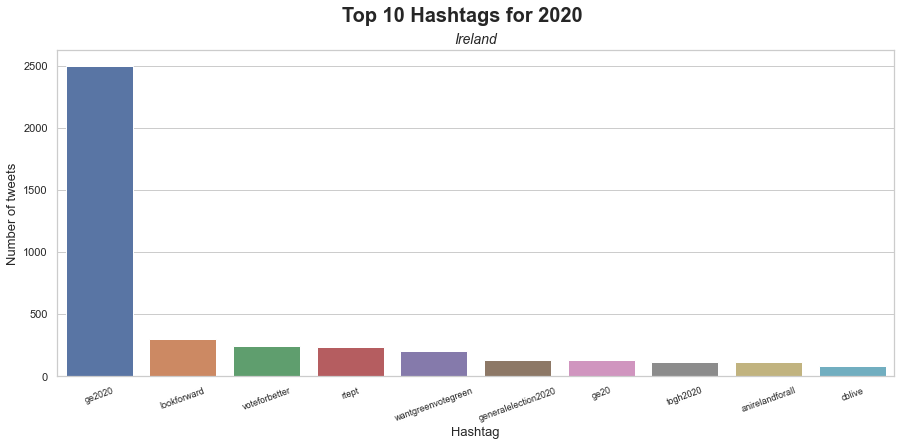

In [148]:
# Plot for 2020
bar_plots("index", "hashtag", top10_20, "Ireland", "Top 10 Hashtags for 2020", "Hashtag", "Number of tweets")

This plot seems to correctly reflect the conversation on Twitter at the time of the election. The most common hashtag is 'ge2020' which fits as it is the most generic. Smaller parties are likely have been pushing the 'lookforward', 'voteforbetter', and 'wantgreenvotegreen' hashtags. Finally, the 'cbive' and 'rtept' refer to major television coverage of the election including party leader debates.m

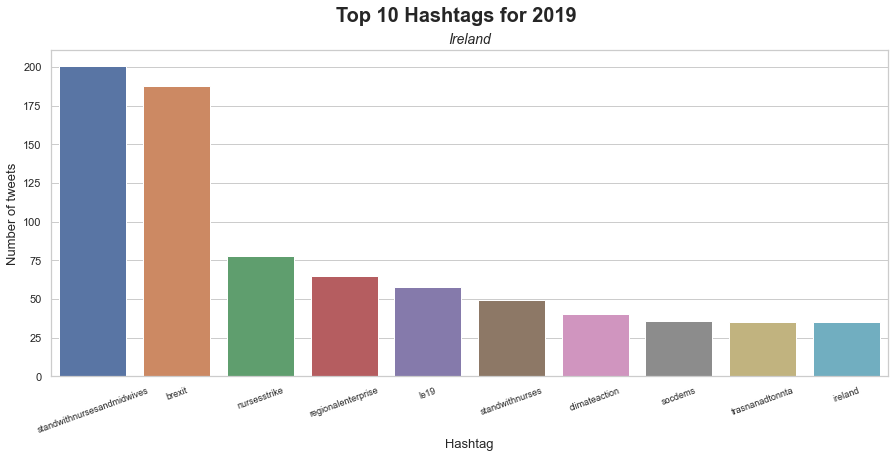

In [149]:
# Plot for 2019
bar_plots("index", "hashtag", top10_19, "Ireland", "Top 10 Hashtags for 2019", "Hashtag", "Number of tweets")

As before, this plot seems to correctly reflect the discourse on Twitter at the time. There were major hospital strikes and Brexit negotiations in February 2019 which are of course relevant for political actors.

### Exercise 2. 

Who are the politicians that use 1 more hashtags in the time period around the elections? Consider the top 5 politicians in terms of hashtag use and plot their relative usage 2with daily level aggregation (focus only on the week before and after the election periods). Comment, do you see some interesting facts?

In [181]:
# We have to consider only self made tweets 
no_retweet_20 = df_20.loc[df_20["retweeted_user_id"].isna() & df_20['in_reply_to_user_id'].isna() & df_20['quoted_user_id'].isna()]
print(no_retweet_20.shape)

(2134, 74)


In [182]:
# Data frame with the hashtags
a = pd.DataFrame(list(hash_retrieve(no_retweet_20)), columns=['hashtag', 'id'])
print(a.shape)

(3031, 2)


In [183]:
# Merging to get the hashtags with its respectively usernames
hashtags_users = pd.merge(a, 
                          no_retweet_20[["id", 'author.id', 'author.username', 'author.name', 'created_at']],
                          on='id',how='left')
hashtags_users.head()

,hashtag,id,author.id,author.username,author.name,created_at
0,GE2020,1228460983636709377,39472243,AlanFarrell,Alan Farrell TD,2020-02-14T23:28:16.000Z
1,justiceforcesupervisors,1228377556681920512,116422140,alankellylabour,Alan Kelly TD,2020-02-14T17:56:46.000Z
2,Cavan,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14T17:32:04.000Z
3,Monaghan,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14T17:32:04.000Z
4,NorthMeath,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14T17:32:04.000Z


In [184]:
# Convert dates to local time
date_time(hashtags_users,'created_at','no','Etc/GMT+1')
hashtags_users['date_new'] = hashtags_users['date_new'].dt.date # get only the date

# Print the new dataframe
print(hashtags_users.shape)
hashtags_users.head()

(3031, 7)


,hashtag,id,author.id,author.username,author.name,created_at,date_new
0,GE2020,1228460983636709377,39472243,AlanFarrell,Alan Farrell TD,2020-02-14 23:28:16,2020-02-14
1,justiceforcesupervisors,1228377556681920512,116422140,alankellylabour,Alan Kelly TD,2020-02-14 17:56:46,2020-02-14
2,Cavan,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14 17:32:04,2020-02-14
3,Monaghan,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14 17:32:04,2020-02-14
4,NorthMeath,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14 17:32:04,2020-02-14


In [185]:
# Top five of politicians that use more hashtags in the time period around the elections
tags_used_user = hashtags_users["author.name"].value_counts()[:5]
tags_used_user

Niamh Smyth TD          146
Billy Timmins           144
Michael Healy-Rae       142
Josepha Madigan ⚖️✨     135
Richard Boyd Barrett    106
Name: author.name, dtype: int64

In [186]:
# Computing the total hashtags used per day
hashtags_day = hashtags_users["date_new"].value_counts().to_frame(name="hashtags_day").rename_axis('date_new').reset_index()
hashtags_day.head()

,date_new,hashtags_day
0,2020-02-07,406
1,2020-02-05,383
2,2020-02-08,378
3,2020-02-03,360
4,2020-02-06,351


In [187]:
# Getting the total hashtag per day of the top tags users and their relative frequency

# filter by the top 5 users 
hashtags_users_5 = hashtags_users[hashtags_users["author.name"].isin(tags_used_user.reset_index()["index"].to_list())]

# Counts per user per day
users_5_day = hashtags_users_5.groupby(["author.name", "date_new"]).size().to_frame(name="hashtags_produced").reset_index()

# Merging and computing the relative frequency
users_5_day = pd.merge(users_5_day, hashtags_day, on='date_new',how='left')
users_5_day["relative_usage"] = users_5_day["hashtags_produced"]/users_5_day["hashtags_day"]
users_5_day["date_new"] = pd.to_datetime(users_5_day["date_new"])

users_5_day.head()


,author.name,date_new,hashtags_produced,hashtags_day,relative_usage
0,Billy Timmins,2020-02-01,42,302,0.139073
1,Billy Timmins,2020-02-03,10,360,0.027778
2,Billy Timmins,2020-02-04,10,343,0.029155
3,Billy Timmins,2020-02-05,19,383,0.049608
4,Billy Timmins,2020-02-06,34,351,0.096866


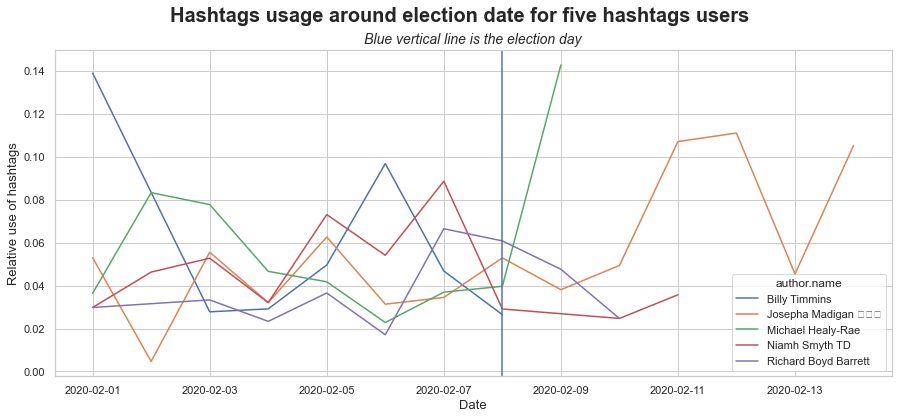

In [188]:
# Plot
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = "date_new", y = "relative_usage", data = users_5_day, hue="author.name")
plt.axvline(x=datetime(2020,2,8))

plt.title('Blue vertical line is the election day',fontsize=14, style="italic")
plt.suptitle("Hashtags usage around election date for five hashtags users", weight="bold").set_fontsize('20')
plt.xlabel("Date").set_fontsize('13')
plt.ylabel("Relative use of hashtags").set_fontsize('13')

There are a number of things to note in this graph. Firstly, the politicians included come from all ends of the political spectrum. From this we might suggest that ideology/party membership does let us predict frequency of hashtag use (obviously big claim with only sample of five). Next, only one of the five is not now a TD (Billy Timmins and he did not run in the election). This might suggest that those who use more hashtags are more likely to be elected (again sample tiny). 

There does not appear to be a trend among the politicians in tweeting a lot of hashtags just before or after the election date. Michael Healy-Rae's relative use of hastags peaks the day after the election and then he does not tweet again. Meanwhile, Billy Timmins' use peaks a week before the vote and he does not use them again after the 8th.

### Exercise 3. 
Can you select the top used emojis in your data? Similarly, create a code that takes the tweets’ text as input and transforms it to a demojized text column. Importantly, emojis need to be converted to the text that matches your specific language.

In [158]:
# First define a function to extract the emojis using the emoji module
def extract_emojis(text):
  return ''.join(emj for emj in text if emj in emoji.UNICODE_EMOJI['en'])

In [159]:
# Top used emojis in the column text and create a new column 
df_20_2 = df_20.copy()
df_20_2['emojis'] = pd.Series([extract_emojis(i) for i in df_20_2['text']])

In [160]:
# Creation of a demojized text column nad if there areno emojis transform them to NaN
df_20_2['demojized_text']= pd.Series([emoji.demojize(i) for i in df_20_2['emojis']]).replace(r'^\s*$', np.nan, regex=True)

In [161]:
emoji_df = df_20_2[['text', 'emojis', 'demojized_text']]
print(emoji_df.shape)
emoji_df.head()

(8464, 3)


,text,emojis,demojized_text
0,"Enjoyable night in Carrick-on-Shannon at Leitrim @IFAmedia dinner to pay tribute to Adrian Leddy’s 45 year contribution to Irish farming. Pictured with Pat Murphy, Chairman Connacht IFA. https://t.co/5UUdwvAgZG",,NaN
1,Last of the posters coming down across the constituency today. #GE2020 https://t.co/XwbAwcYzGI,,NaN
2,@Grahamiii Will retrieve Graham. A few stragglers left.. https://t.co/aP7QGTd83M,,NaN
3,So delighted to hear this - and more than happy to help 💪💪💪 https://t.co/7yxqKk625p,💪💪💪,:flexed_biceps::flexed_biceps::flexed_biceps:
4,"Enjoyable night in Carrick-on-Shannon at Leitrim @IFAmedia dinner to pay tribute to Adrian Leddy’s 45 year contribution to Irish farming. Pictured with Pat Murphy, Chairman Connacht IFA. https://t.co/5UUdwvAgZG",,NaN


In [162]:
# We will remove the NaNs
emoji_df.dropna(inplace=True)
print(emoji_df.shape)

# Create a dataframe with the emojis and its frequency
emoji_top = emoji_df['demojized_text']
emoji_top = sum([re.findall(':(.+?):', i) for i in emoji_top], [])
emoji_top = pd.DataFrame([(i,emoji_top.count(i)) for i in set(emoji_top)])
emoji_top.head()

# Create the dataframe with the top 10 by frequency
top_emojis = emoji_top.rename(columns={0: 'Emoji_demojized', 1:'Count'}).sort_values('Count', ascending = False)
top_emojisplot = top_emojis.head(10)
top_emojisplot['Emoji'] = [emoji.emojize(':'+i+':') for i in top_emojisplot['Emoji_demojized']]
top_emojisplot

(1344, 3)


,Emoji_demojized,Count,Emoji
273,check_mark_button,191,✅
249,ballot_box_with_ballot,178,🗳️
163,rose,156,🌹
2,green_heart,146,💚
172,check_mark,124,✔️
189,purple_heart,119,💜
169,clapping_hands,101,👏
237,face_with_tears_of_joy,76,😂
64,red_heart,73,❤️
138,thumbs_up,70,👍


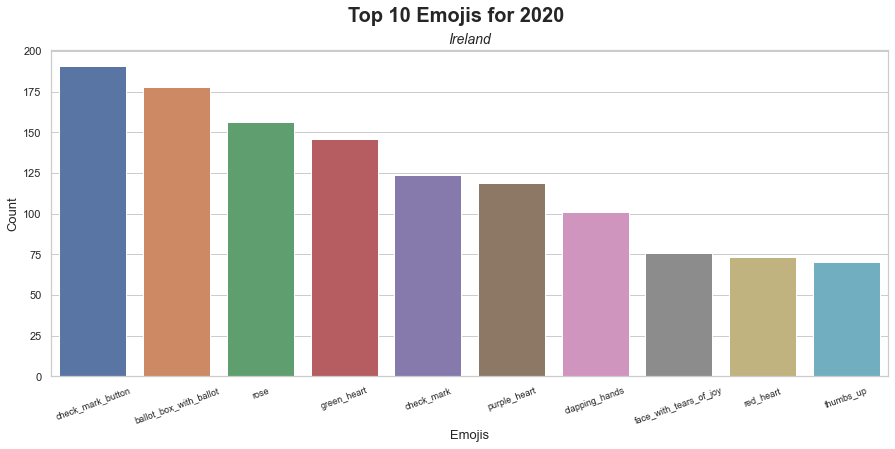

In [163]:
# Barplot for top emojis 
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x="Emoji_demojized", y="Count", data=top_emojisplot)
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation = 20, size=9)
plt.title('Ireland',fontsize=14, style="italic")
plt.suptitle("Top 10 Emojis for 2020", weight="bold").set_fontsize('20')
plt.xlabel("Emojis").set_fontsize('13')
plt.ylabel("Count").set_fontsize('13')

As we saw in the case of the hashtags, the emoji use closely follows what we might expect. The check marks and ballot boxes are understood to indicate having voted. The coloured hearts and rose emoji are the emojis associated with various Irish political parties (green heart = Green Party, rose = Labour Party etc). Clapping hands, face with tears of joy, and thumbs up are more generic of course but the absence of any unexpected emojis is encouraging.

### Exercise 4. 
Repeat exercise 1 for the dataset that you obtained about Miami beach. What was going on in Miami those days?

In [18]:
# Download the data of Miami with the correct query
!twarc2 search --archive --start-time "2019-03-29" --end-time "2019-03-31" "point_radius:[-80.1709 25.7423 3.11mi]" files/miami.jsonl
!twarc2 csv files/miami.jsonl files/miami.csv

100%|██████████████| Processed 3.45M/3.45M of input file [00:01<00:00, 3.46MB/s]

ℹ️
Parsed 1436 tweets objects from 15 lines in the input file.
Wrote 1436 rows and output 74 columns in the CSV.



In [164]:
# Load the data into pandas df
miami_df = pd.read_csv("files/miami.csv")
miami_df[miami_df.columns[pd.Series(miami_df.columns).str.startswith('geo')]].head()

,geo.coordinates.coordinates,geo.coordinates.type,geo.country,geo.country_code,geo.full_name,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type
0,"[-80.18541, 25.77161]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city
1,NaN,NaN,Estados Unidos,US,Marlins Park,"[-80.22144846000792, 25.778580385989454, -80.22144846000792, 25.778580385989454]",Feature,07d9d339c4084000,Marlins Park,07d9d339c4084000,poi
2,"[-80.192, 25.7752]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city
3,"[-80.18997042, 25.7584841]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city
4,"[-80.16957, 25.7767103]",Point,Estados Unidos,US,"Florida, USA","[-87.634643, 24.396308, -79.974307, 31.001056]",Feature,4ec01c9dbc693497,Florida,4ec01c9dbc693497,admin


In [165]:
# Retrieve the hashtags using the function
hashtags_miami = pd.DataFrame(list(hash_retrieve(miami_df)), columns=['hashtag', 'id'])

In [166]:
# Top 10 hasgtags df
hashtags_miami["hashtag"] = hashtags_miami["hashtag"].str.lower() # Convert everything to lowercase 
top10_miami = hashtags_miami['hashtag'].value_counts()[:10].to_frame().reset_index()

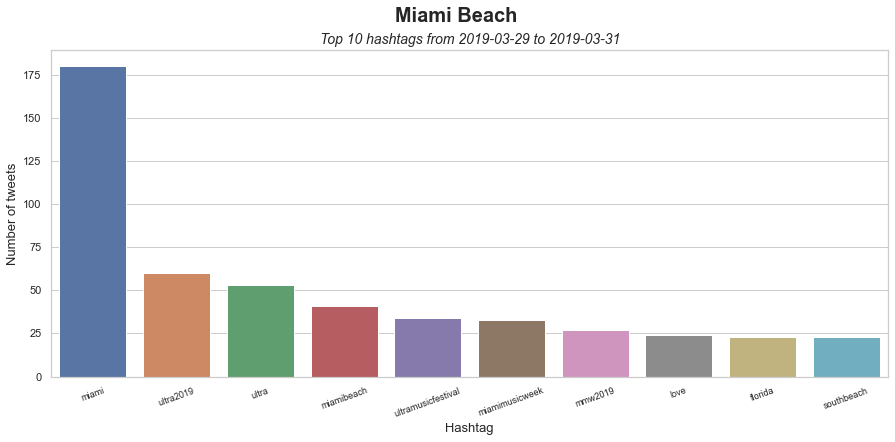

In [167]:
# Plot
bar_plots("index", "hashtag", top10_miami, "Top 10 hashtags from 2019-03-29 to 2019-03-31", "Miami Beach", "Hashtag", "Number of tweets")

Looking to the bar chart we can see that the Ultra Music Festival is going on in Miami during our timeframe.

### Exercise 5. 
Using Miami’s dataset, complete the following function (preferably using python) using python:

In [ ]:
def map_tweets (df , center_coords , filename ):
    """
    Goes from a tweet df and outputs the html map of the geoccordinates .
    df: Dataframe | of tweets that contain geolocation
    center_coords : list | [lat ,lng ] of the centered point of the map
    filename : str | name of the output file in html format
    """

In [169]:
# Function
def map_tweets(df , center_coords, filename):
    """
    Goes from a tweet df and outputs the html map of the geoccordinates .
    df: Dataframe | of tweets that contain geolocation
    center_coords : list | [lat ,lng ] of the centered point of the map
    filename : str | name of the output file in html format
    """
    df2 = df.copy() # Copying the data frame
    df2 = df2.dropna(axis = 0, subset = ["geo.coordinates.coordinates"]) # Drop the rows without coordinates

    latitud = df2["geo.coordinates.coordinates"].apply(lambda x: re.findall('-?\d+\.\d+', x)[1]) # Get latitud
    longitude = df2["geo.coordinates.coordinates"].apply(lambda x: re.findall('-?\d+\.\d+', x)[0]) # Get longitude

    # Print a map centered at Miami
    miami_map = folium.Map(location=center_coords, zoom_start=12)

    # Looping over each row (point) to add it in the map 
    for point in latitud.index:
        folium.CircleMarker(location=[latitud[point], longitude[point]], radius=2, color = 'red', fill_color = 'red').add_to(miami_map)
        
    miami_map.save(filename) # Save the map

In [170]:
# Export the map in html format
map_tweets(miami_df , [25.7423, -80.1709], 'files/miami_tweets_map.html')

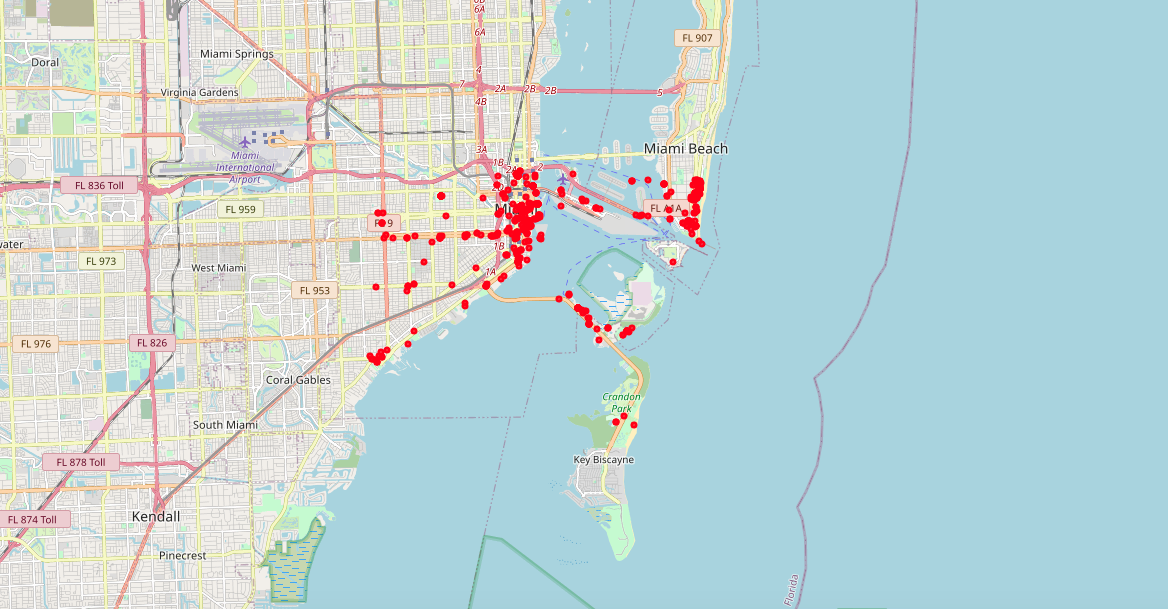

### Output format:

In [141]:
# Join 2019 and 2020 data
df_politics = pd.concat([df_19, df_20], axis = 0, ignore_index=True)
print(df_politics.shape)

# tweet_hashtags column
df_politics['tweet_hashtags'] = df_politics['text'].str.findall(r'\#([\d\w]+)').astype(str).replace("[]", np.nan)

# demojized_text (using the default language: English)
df_politics['demojized_text'] = pd.Series(emoji.demojize(i) for i in df_politics['text'])

# group country
df_politics['group_country'] = 'Ireland'

(14006, 74)


In [142]:
# Politicians' parties
parties = pd.read_csv("files/with_parties.csv", sep = ",", names = ["author.username_lower", "party"]) # load the data of parties
parties.drop_duplicates(inplace=True) # Delete duplicates


df_politics['author.username_lower'] = df_politics['author.username'].str.lower()

print(df_politics.shape)
df_politics2 = pd.merge(df_politics, parties, on =  "author.username_lower", how = 'left')
print(df_politics2.shape)

# Delete the author.username_lower var
df_politics2.drop(['author.username_lower'], axis=1, inplace=True)
print(df_politics2.shape)

(14006, 78)
(14006, 79)
(14006, 78)


In [178]:
# Having a look at the new columns
df_politics2.loc[df_politics2['tweet_hashtags'].notna() & (df_politics2['text'] != df_politics2['demojized_text']), ['text','tweet_hashtags', 'demojized_text','group_country','party']].tail(10)

,text,tweet_hashtags,demojized_text,group_country,party
13809,"📺Is another election coming down the tracks as Fianna Fáil dismiss talks with Sinn Féin?\n\nAnd if the economy is thriving, why are so many people voting for change?\n\nJoining us:\n| @danobrien20 | Larissa Nolan | @Dunphy_Official | @Donnchadhol | @AnneRabbitte | #TonightVMT...",['TonightVMTV'],":television:Is another election coming down the tracks as Fianna Fáil dismiss talks with Sinn Féin?\n\nAnd if the economy is thriving, why are so many people voting for change?\n\nJoining us:\n| @danobrien20 | Larissa Nolan | @Dunphy_Official | @Donnchadhol | @AnneRabbitte | ...",Ireland,Sinn Fein
13831,"For those wanting to follow the #Waterford #tally tomorrow, I have set up an online realtime tally sheet available here:\nhttps://t.co/9pUWtC6PMN\n\n#GE2020 #GeneralElection2020 \n\nData will be set to 0 at 9am with tallies entered as they come in. 🗳️1⃣ https://t.co/umoHoxzIc7","['Waterford', 'tally', 'GE2020', 'GeneralElection2020']","For those wanting to follow the #Waterford #tally tomorrow, I have set up an online realtime tally sheet available here:\nhttps://t.co/9pUWtC6PMN\n\n#GE2020 #GeneralElection2020 \n\nData will be set to 0 at 9am with tallies entered as they come in. :ballot_box_with_ballot::ke...",Ireland,Green
13842,"Today is polling day but as it happens, is also my birthday 🤫\n\nNot that this should in any way influence your voting preference. But if u can manage a No1 that would be sound😉\n\nCake was gas, thank you to my family who’ve been incredible through this all ❤️\n\n#BirthdaysFo...",['BirthdaysForChange'],"Today is polling day but as it happens, is also my birthday :shushing_face:\n\nNot that this should in any way influence your voting preference. But if u can manage a No1 that would be sound:winking_face:\n\nCake was gas, thank you to my family who’ve been incredible through ...",Ireland,Sinn Fein
13843,Time for new shoes 😉\n\n#GE2020 https://t.co/wSWIgFZEEV,['GE2020'],Time for new shoes :winking_face:\n\n#GE2020 https://t.co/wSWIgFZEEV,Ireland,Green
13879,"Our young people get no say in the future we're carving out for them this Saturday. They deserve the right to protest, to fight for their futures, and to draw attention to the fact they will pay the price of our inaction if we don't #voteforclimate this weekend. 💪🌍 https://t....",['voteforclimate'],"Our young people get no say in the future we're carving out for them this Saturday. They deserve the right to protest, to fight for their futures, and to draw attention to the fact they will pay the price of our inaction if we don't #voteforclimate this weekend. :flexed_bicep...",Ireland,Green
13884,"Give these amazing, hard working, #greens a follow &amp; more importantly a 1⃣ vote for a cleaner, safer, healthier #Ireland:\n@RoisinGarvey \n@saoirse_mchugh \n@rodericogorman \n@MarcKC_Green \n@TheKavOfficial \n@cathmartingreen \n@stevensgreen1 \n@TateForTD \n\n#VoteClimate...","['greens', 'Ireland', 'VoteClimate', 'VoteGreen']","Give these amazing, hard working, #greens a follow &amp; more importantly a :keycap_1: vote for a cleaner, safer, healthier #Ireland:\n@RoisinGarvey \n@saoirse_mchugh \n@rodericogorman \n@MarcKC_Green \n@TheKavOfficial \n@cathmartingreen \n@stevensgreen1 \n@TateForTD \n\n#Vot...",Ireland,Green
13897,"Its disappointing that now that the election is near, southern politicians start to debate about the north 😡 what about the other 11 months of the year or years #onlywhenitsuits",['onlywhenitsuits'],"Its disappointing that now that the election is near, southern politicians start to debate about the north :pouting_face: what about the other 11 months of the year or years #onlywhenitsuits",Ireland,Sinn Fein
13904,"Thank you to all those who look after, love &amp; teach our young children. You need to be better looked after &amp; acknowledged 💚 #oneunitedvoice #childcare @greenparty_ie is committed to reform of system, better pay, less red tape, more availability #GE2020 #WantGree

In [196]:
# Keep only the specified columms
columns_k = ['id', 'conversation_id', 'author_id', 'retweeted_user_id', 'lang', 'public_metrics.like_count', 'public_metrics.quote_count',
'public_metrics.reply_count', 'public_metrics.retweet_count', 'author.created_at', 'author.username', 'author.description',
'geo.coordinates.coordinates', 'geo.coordinates.type', 'geo.country','tweet_hashtags', 'demojized_text','group_country','party']
df_politics2 = df_politics2[, columns_k]
df_politics2.columns()


TypeError: 'Index' object is not callable

In [143]:
# Exporting the data
df_politics2.to_csv("output_format_Ireland.csv", index=False)

## Extra exercises:

**Extra 1:** Suppose that you have a dataset of tweets in different languages and you want to process the text to transform emojis. Can you suggest a way in which you would do this automatically? There is no need to create a code, explaining the basic intuition is fine!

Since the data from twarc includes a column with the language of the tweet ('lang') we can use this information as a parameter into emoji's functions. However, we have to considerer that the module only supports few languages (English, Spanish, Portuguese, Italian, German and French), so this can be a limitiation in some cases.

**Extra 2:** We have seen that only those tweets that attach a picture come with exact geolocation. Knowing this, can you create a python loop that extracts the URLS in those tweets and opens them in your browser. HINTS: There are several ways to do this but you can use regular expressions for the URLS and webbrowser to open them

In [187]:
# Loop for extract the tweets and open them in a new tab of the browser
n = 5 # Number of links to open
for tweet in range(n):
    url = re.findall(r'(https.*)', miami_df['text'][tweet])
    webbrowser.open_new_tab(url[0])

In [171]:
# Improvement by creating a funtion to insert the initial row and final row to loop over
def open_images(df, start, end):
    for tweet in range(start, end):
        url = re.findall(r'(https.*)', df['text'][tweet])
        webbrowser.open_new_tab(url[0])

In [172]:
# Testing the function
open_images(miami_df, 25, 28) # Open the links from the 25th to the 27th tweet in the miami data set